In [1]:
import hotspot
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import anndata as ad
import sys
import bbknn
from statsmodels import robust
import matplotlib.pyplot as plt
import os.path
import harmonypy as hm

In [3]:
#input_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/object/TCL_CLCT_pcALCL_panfetal_scVI_hotspot_neib20_layer1_rmTCRgene.h5ad'
input_file = '/lustre/scratch126/cellgen/teichmann/rl20/TCL/object/TCL_CLCT_pcALCL_panfetal_PIP_scVI_hotspot_neib30_layer1_latent10_fdr0.01_top1000_rmTCRgene.h5ad'
adata = sc.read_h5ad(input_file)

In [4]:
meta = pd.read_csv('/lustre/scratch126/cellgen/teichmann/rl20/TCL/object/TCL_CLCT_pcALCL_panfetal_PIP_scVI_hotspot_neib30_layer1_latent10_fdr0.01_top1000_rmTCRgene_meta.csv')

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (1,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
meta['donor_id'] = adata.obs['donor_id'].copy()

In [6]:
meta['tumour_type'] = adata.obs['tumour_type']

In [7]:
adata.obs = meta
adata.obs

Unnamed: 0                       ID  \
0       AAACCTGAGCCGTCGT-1-TL10712_CD3pos_GEX_CITE-0  TL10712_CD3pos_GEX_CITE   
1       AAACCTGAGGATATAC-1-TL10712_CD3pos_GEX_CITE-0  TL10712_CD3pos_GEX_CITE   
2       AAACCTGCAAGAAAGG-1-TL10712_CD3pos_GEX_CITE-0  TL10712_CD3pos_GEX_CITE   
3       AAACCTGCAGCATGAG-1-TL10712_CD3pos_GEX_CITE-0  TL10712_CD3pos_GEX_CITE   
4       AAACCTGCATGGTCAT-1-TL10712_CD3pos_GEX_CITE-0  TL10712_CD3pos_GEX_CITE   
...                                              ...                      ...   
580790                 CZINY-0112_TTTGGTTAGGCCACTC-4                      NaN   
580791                 CZINY-0112_TTTGGTTCACAAAGTA-4                      NaN   
580792                 CZINY-0112_TTTGGTTTCCATCACC-4                      NaN   
580793                 CZINY-0112_TTTGTTGCAGCGGTTC-4                      NaN   
580794                 CZINY-0112_TTTGTTGGTGCGACAA-4                      NaN   

       donor_id tumour_type study malignant_call malignant_call2  \
0           NaN         NaN   TCL         benign     benign_AITL   
1           NaN         NaN   TCL         benign     benign_AITL   
2           NaN         NaN   TCL          malig      malig_AITL   
3           NaN         NaN   TCL         benign     benign_AITL   
4           NaN         NaN   TCL          malig      malig_AITL   
...         ...         ...   ...            ...             ...   
580790      NaN         NaN   PIP         benign      benign_PIP   
580791      NaN         NaN   PIP         benign      benign_PIP   
580792      NaN         NaN   PIP         benign      benign_PIP   
580793      NaN         NaN   PIP         benign      benign_PIP   
580794      NaN         NaN   PIP         benign      benign_PIP   

                malignant_call_donor        celltype_annotation  n_genes  ...  \
0                        benign_AITL                        NaN     1351  ...   
1                        benign_AITL                        NaN      296  ...   
2                      malig_TL10712                        NaN      961  ...   
3                        benign_AITL                        NaN      507  ...   
4                      malig_TL10712                        NaN     1045  ...   
...                              ...                        ...      ...  ...   
580790          PIPCytotoxic T cells          Cytotoxic T cells     1668  ...   
580791             PIPHelper T cells             Helper T cells     1967  ...   
580792          PIPCytotoxic T cells          Cytotoxic T cells     1617  ...   
580793  PIPFollicular helper T cells  Follicular helper T cells     1512  ...   
580794          PIPCytotoxic T cells          Cytotoxic T cells     1355  ...   

        Module 12  Module 13  Module 14  Module 15  Module 16  Module 17  \
0       -0.188178  -0.751969   0.458961  -0.271205   0.014309  -0.527307   
1       -0.196011  -0.750204  -0.178618  -0.472180  -0.334872  -0.395931   
2       -0.466654  -0.749845   2.944334  -0.378576   4.300879   0.260190   
3       -0.179332  -1.103340  -0.166767  -0.375791   0.906565  -0.328883   
4       -0.404604  -1.151020   0.035888  -0.886620   0.707432  -0.565568   
...           ...        ...        ...        ...        ...        ...   
580790  -0.268194  -1.176835  -0.853864  -0.222541  -0.743609  -0.486737   
580791  -0.394103  -1.380401  -0.654113  -0.927822  -0.663781  -0.804627   
580792  -0.599940  -1.288198  -0.656119  -0.098298  -0.818818  -0.677212   
580793  -0.392686  -1.369573  -0.513662  -1.112989  -0.675836  -0.772536   
580794  -0.230363  -1.359764  -0.517331  -0.527396  -0.766994  -0.574482   

        Module 18  Module 19  Module 20  malignant_call_tumour_type  
0        0.478619  -0.040327   0.221058                 benign_AITL  
1       -0.877445   0.716954  -0.719669                 benign_AITL  
2       -0.513280  -0.036373   0.941947                  malig_AITL  
3       -0.590016  -0.034735   1.643139                 benign_AITL  
4       -0.68831

In [8]:
#adata = adata[~adata.obs['malignant_call_donor'].isin(['benign_ALCL'])].copy()
#adata

In [9]:
#input_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/object/Integrated_PTCL_CTCL_pcALCL_panfetal_raw_forscVI.h5ad'
#adata2 = sc.read_h5ad(input_file)

In [10]:
adata.obs['malignant_call_donor'].value_counts()

benign_CTCL                       105335
PIPCytotoxic T cells               63050
PIPHelper T cells                  30086
PIPTem/Effector helper T cells     23664
PIPTcm/Naive helper T cells        23659
                                   ...  
panfetal_TYPE_1_INNATE_T             445
malig_TL2860                         338
malig_TL_Mangosteen                  295
benign_BIA-ALCL                      148
benign_PIP                           107
Name: malignant_call_donor, Length: 63, dtype: int64

In [11]:
adata

AnnData object with n_obs × n_vars = 580795 × 2000
    obs: 'Unnamed: 0', 'ID', 'donor_id', 'tumour_type', 'study', 'malignant_call', 'malignant_call2', 'malignant_call_donor', 'celltype_annotation', 'n_genes', 'Module 1', 'Module 2', 'Module 3', 'Module 4', 'Module 5', 'Module 6', 'Module 7', 'Module 8', 'Module 9', 'Module 10', 'Module 11', 'Module 12', 'Module 13', 'Module 14', 'Module 15', 'Module 16', 'Module 17', 'Module 18', 'Module 19', 'Module 20', 'malignant_call_tumour_type'
    var: 'gene_ids-0', 'feature_types-0', 'gene_ids-1', 'feature_types-1', 'GeneID-2', 'GeneName-2', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'scvi_model_var-2', 'gene_ids-3', 'feature_types-3', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'malignant_call_donor_colors', 'malignant_call_tumour_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', '

In [12]:
module_cols = []
for c in range(1,21):
    key = f"Module {c}"
    #adata.obs[key] = module_scores[c]
    module_cols.append(key)

In [13]:
#mod_score = adata.obs[module_cols]

In [14]:
#mod_score.to_csv('/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/object/Score_TCL_CLCT_pcALCL_panfetal_scVI_hotspot_neib30_layer1_latent10_fdr0.01_rmTCRgene.csv')

In [14]:
adata.obs['malignant_call_donor'] = adata.obs['malignant_call_donor'].astype('object')
adata.obs.loc[(adata.obs['donor_id']=='TL5493') & (adata.obs['malignant_call']=='benign'), 'malignant_call_donor'] = 'benign_nTFHL'
adata.obs.loc[(adata.obs['donor_id']=='TL8441') & (adata.obs['malignant_call']=='benign'), 'malignant_call_donor'] = 'benign_nTFHL'

In [15]:
adata.obs['malignant_call_donor2'] = adata.obs['malignant_call_donor'].copy()
adata.obs['malignant_call_donor2'] = adata.obs['malignant_call_donor2'].astype('str')
adata.obs.loc[adata.obs['study'].isin(['PIP']), 'malignant_call_donor2'] = 'benign_PIP'
adata.obs.loc[adata.obs['study'].isin(['panfetal_TH']), 'malignant_call_donor2'] = 'benign_TH_panfetal'

In [23]:
adata.obs['malignant_call2'] = adata.obs['malignant_call2'].astype('str')
adata.obs.loc[(adata.obs['donor_id']=='TL5493') & (adata.obs['malignant_call']=='benign'), 'malignant_call2'] = 'benign_nTFHL'
adata.obs.loc[(adata.obs['donor_id']=='TL8441') & (adata.obs['malignant_call']=='benign'), 'malignant_call2'] = 'benign_nTFHL'
adata.obs.loc[(adata.obs['donor_id']=='TL5493') & (adata.obs['malignant_call']=='malig'), 'malignant_call2'] = 'malig_nTFHL'
adata.obs.loc[(adata.obs['donor_id']=='TL8441') & (adata.obs['malignant_call']=='malig'), 'malignant_call2'] = 'malig_nTFHL'

In [16]:
adata = adata[~adata.obs['malignant_call_donor'].isin(['benign_PIP'])].copy() ### remove benign_PIP: CD8a/b enrty, because in Thymus dataset, there is CD8a/b enrty

In [17]:
adata.obs['malignant_call_donor'].value_counts()

benign_CTCL                       105335
PIPCytotoxic T cells               63050
PIPHelper T cells                  30086
PIPTem/Effector helper T cells     23664
PIPTcm/Naive helper T cells        23659
                                   ...  
malig_TL6722                         509
panfetal_TYPE_1_INNATE_T             445
malig_TL2860                         338
malig_TL_Mangosteen                  295
benign_BIA-ALCL                      148
Name: malignant_call_donor, Length: 63, dtype: int64

In [18]:
#adata.obs[adata.obs['malignant_call_donor']=='benign_PIP']

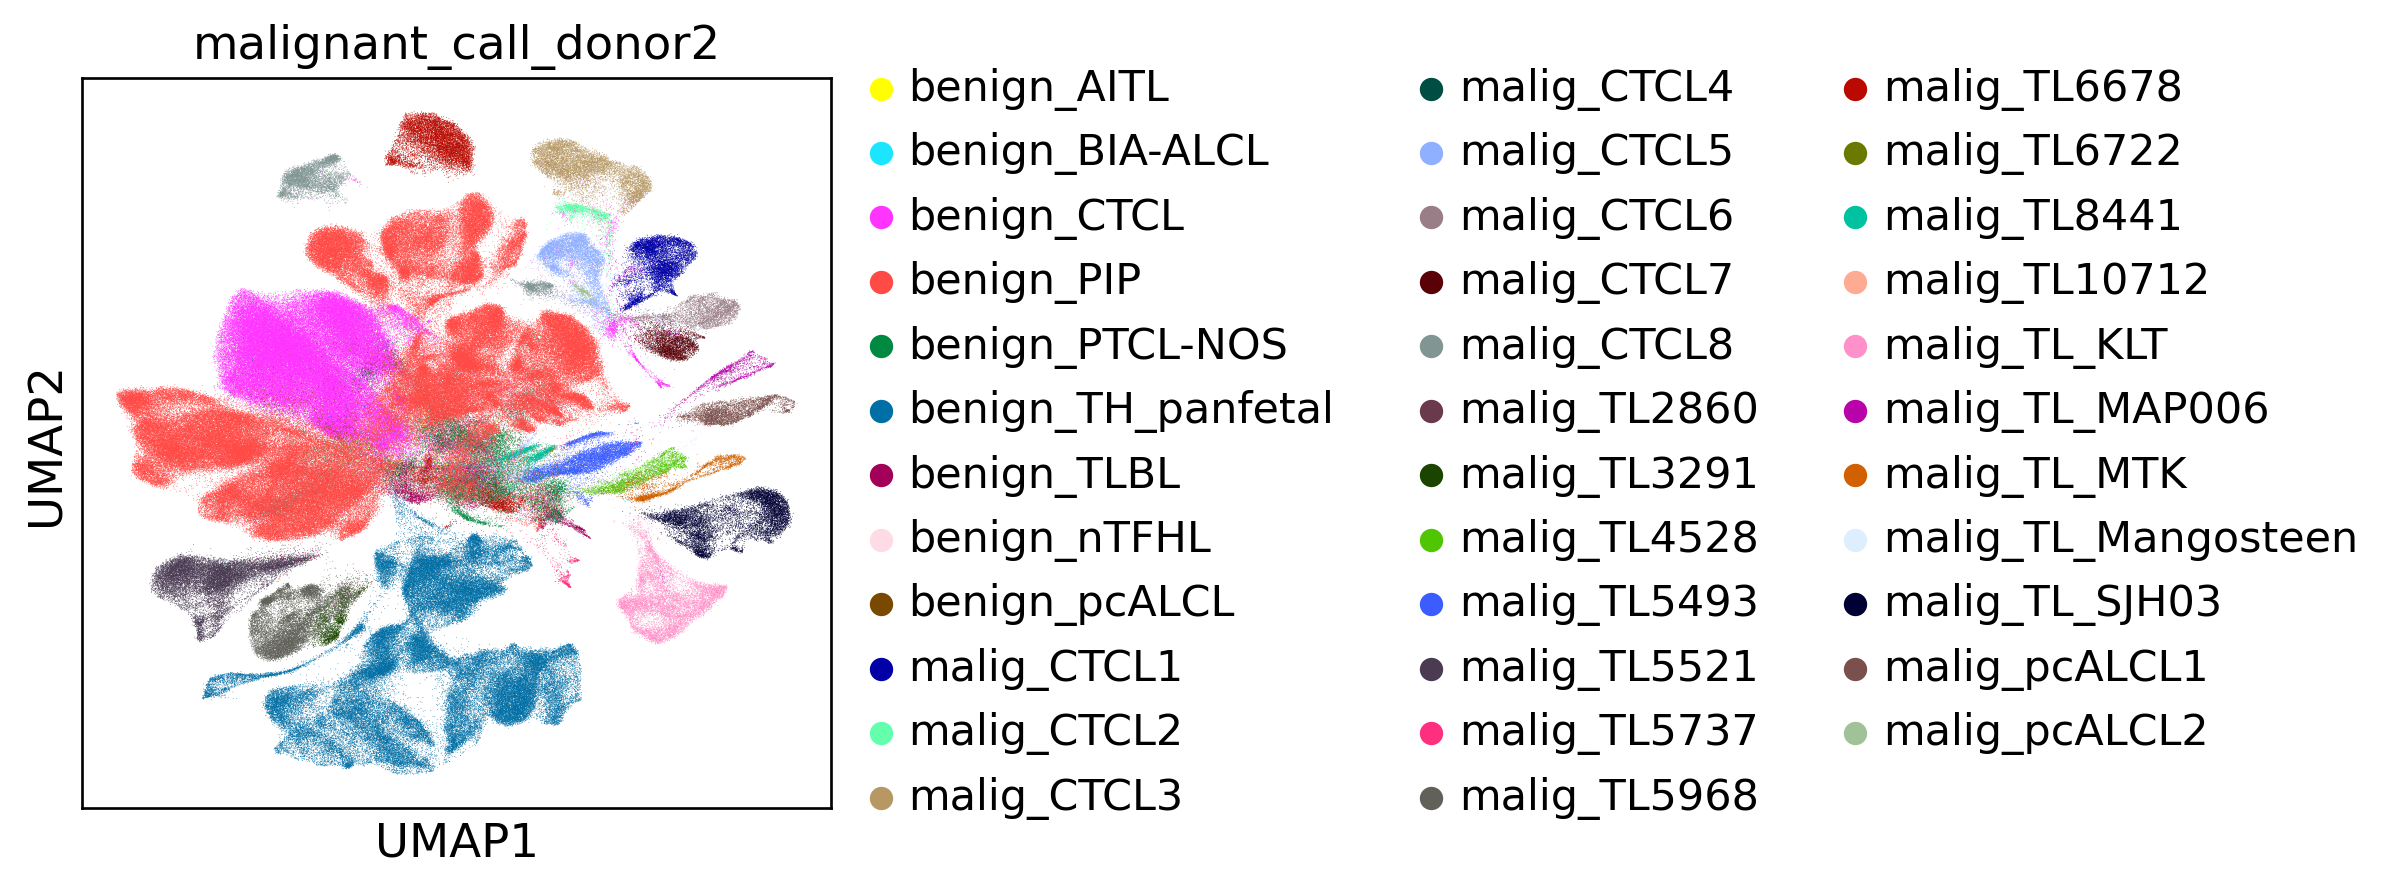

In [22]:
sc.settings.set_figure_params(dpi=120, facecolor='white')
sc.pl.umap(adata, color=['malignant_call_donor2'])

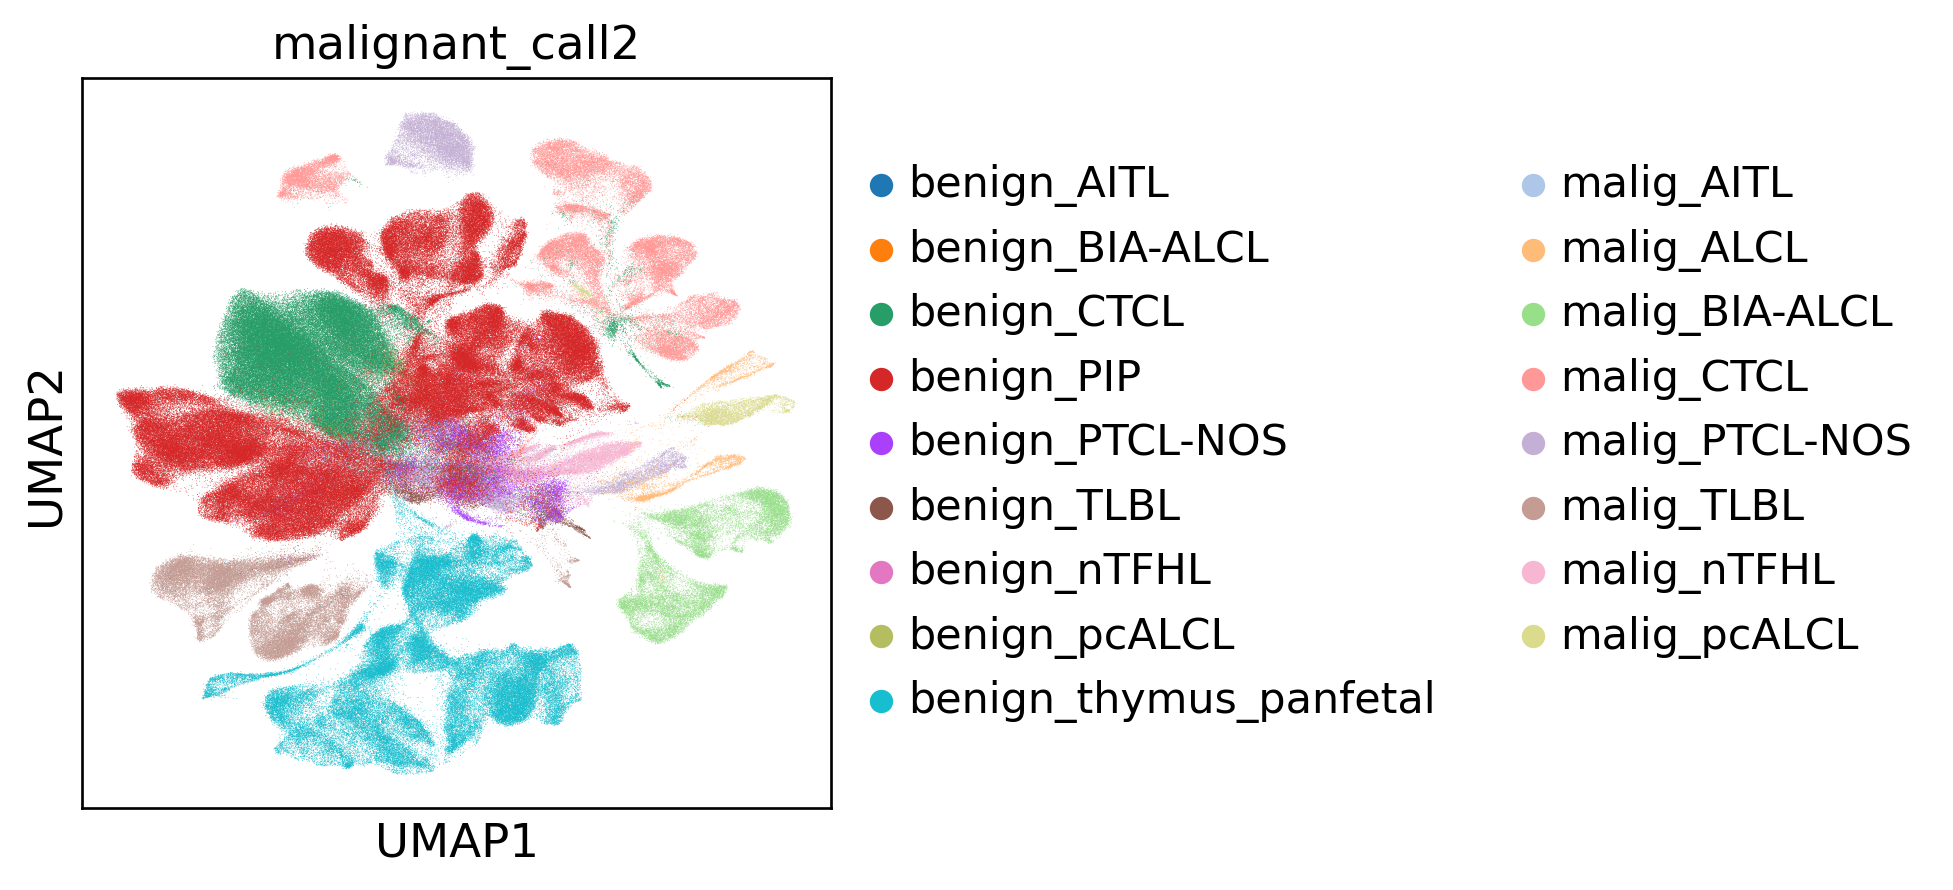

In [24]:
sc.settings.set_figure_params(dpi=120, facecolor='white')
sc.pl.umap(adata, color=['malignant_call2'])

In [25]:
col = ['#BAB1A7','#60528F',
 '#BFA829','#BFD03F','#7982E3','#C2501E','#EC6CDD',
 '#75CFC1','#794FE0','#A1208F']

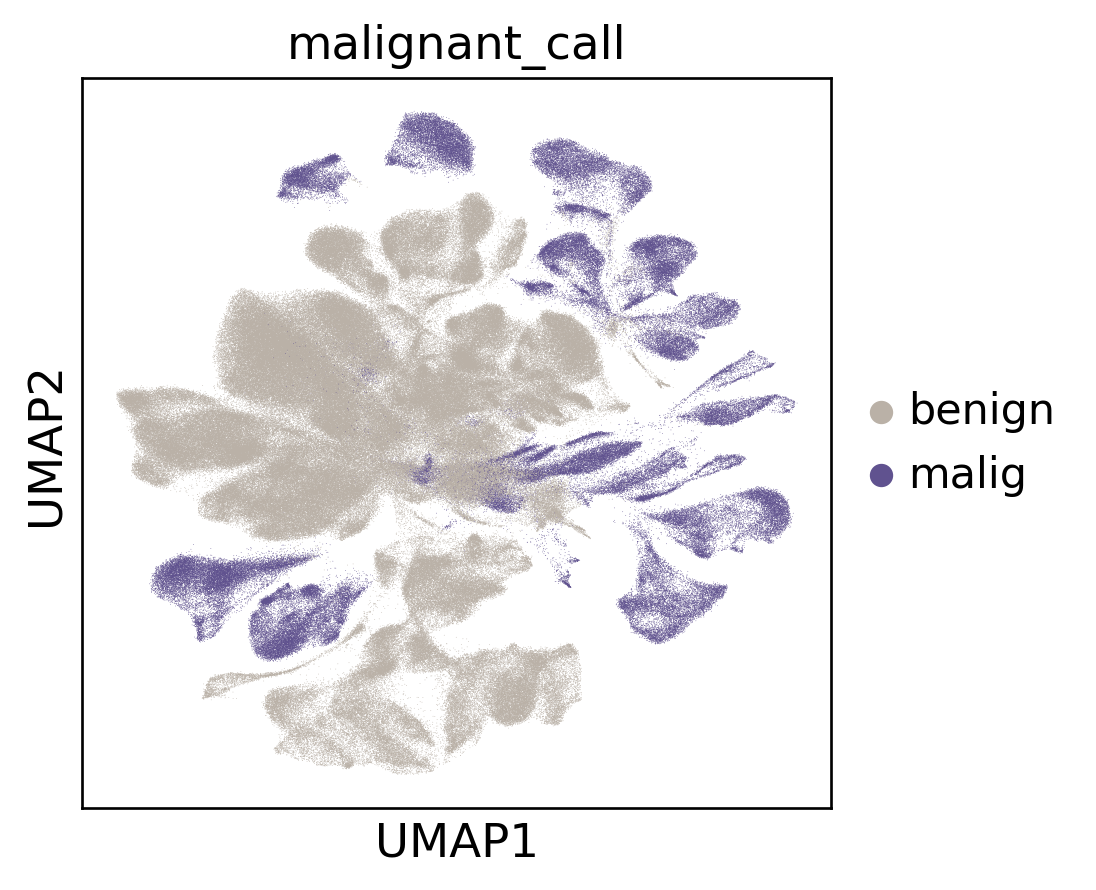

In [26]:
sc.settings.set_figure_params(dpi=120, facecolor='white')
sc.pl.umap(adata, color=['malignant_call'],palette = col)

In [24]:
adata.raw.X.shape

(580795, 19024)

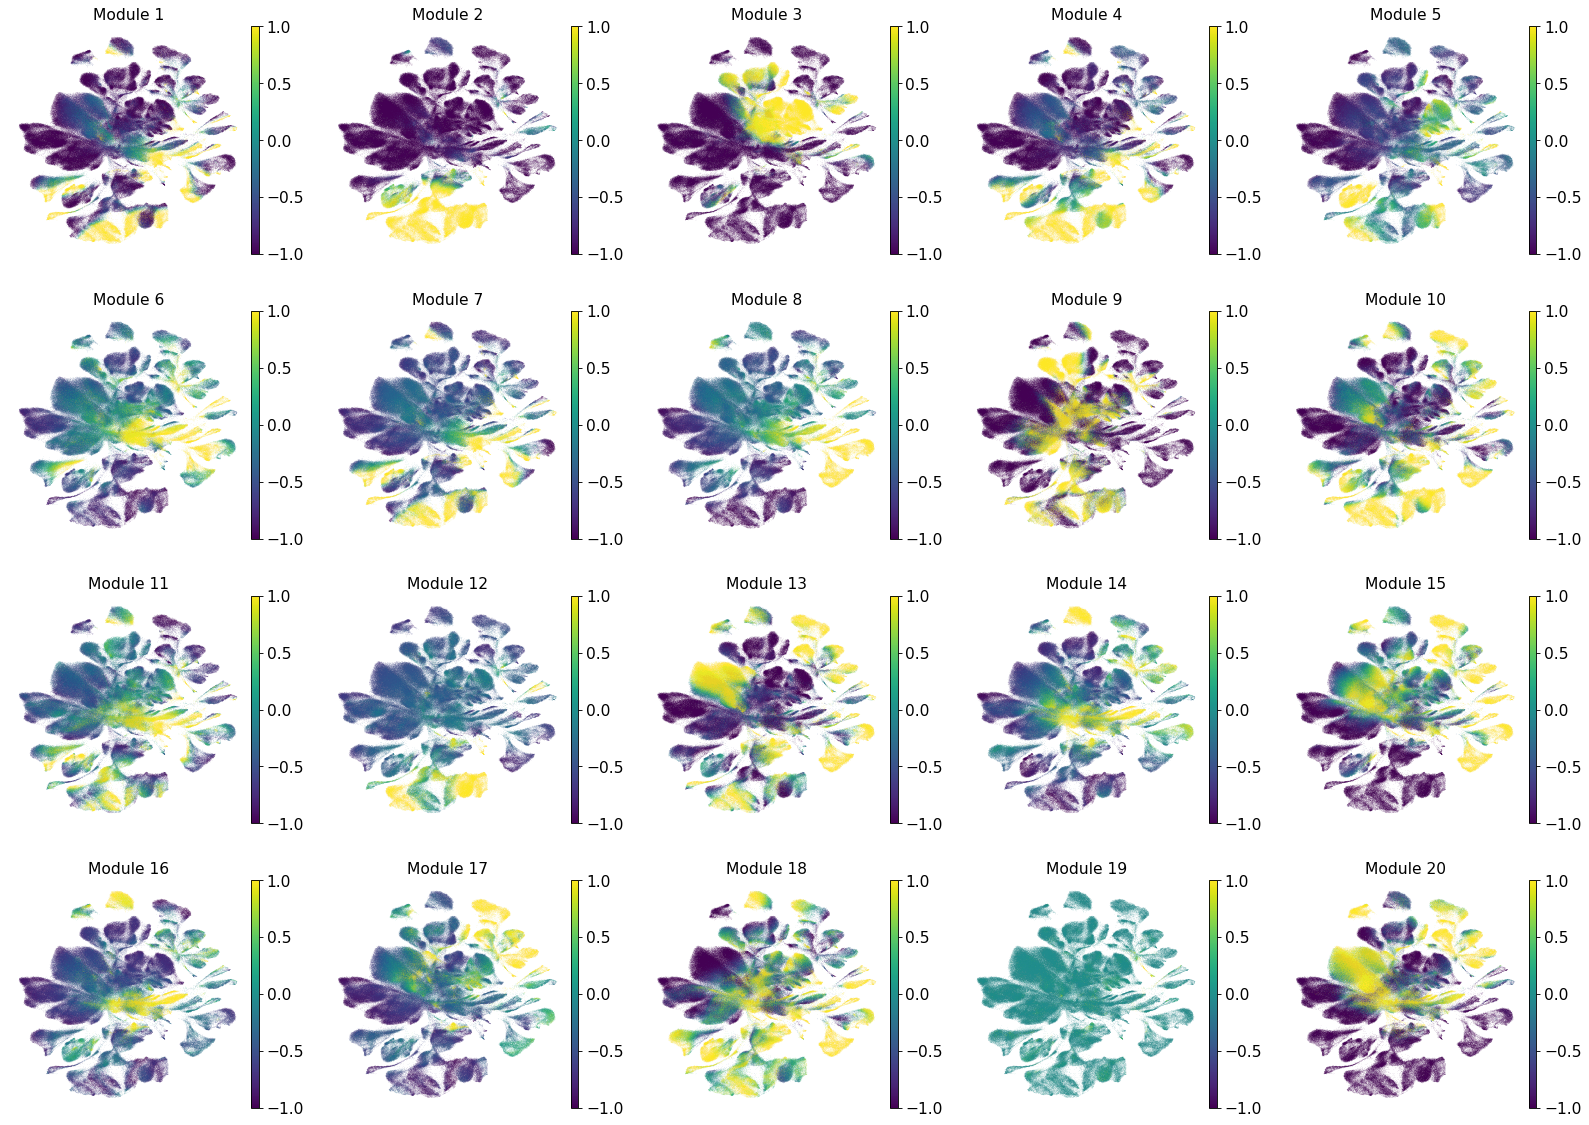

In [32]:
sc.settings.set_figure_params(dpi=40, facecolor='white')
sc.pl.umap(adata, color=module_cols, frameon=False, vmin=-1, vmax=1, ncols=5)

In [29]:
#dp = sc.pl.dotplot(adata, module_cols, groupby='malignant_call_donor', 
#                   dendrogram = True, vmax=8, cmap='gray_r')


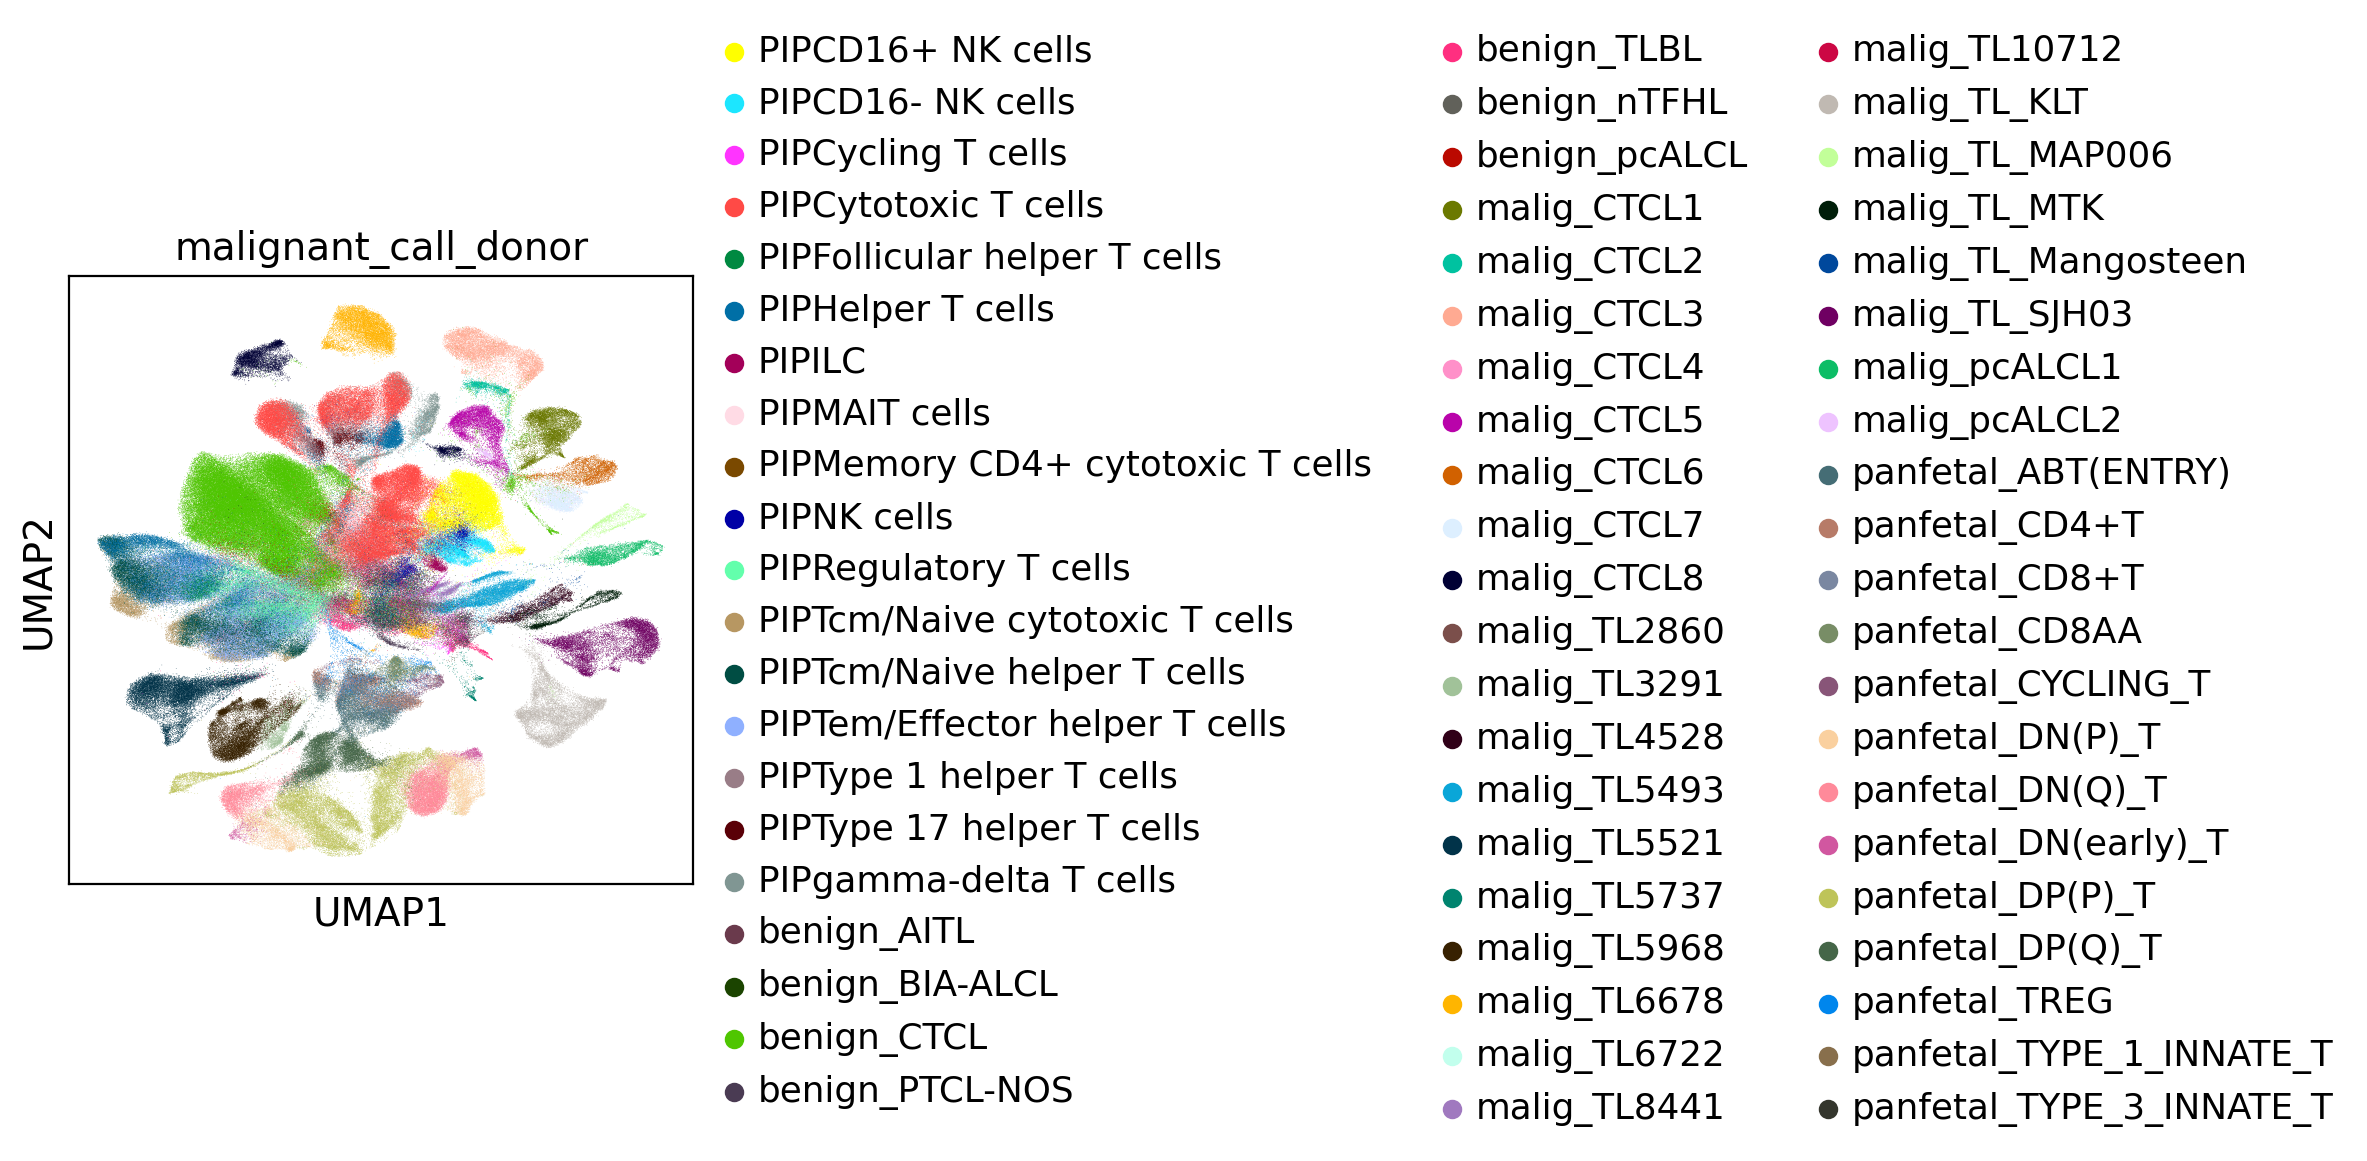

In [33]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata, color=['malignant_call_donor'])

In [34]:
categories_order = ['panfetal_DN(early)_T','panfetal_DN(Q)_T','panfetal_DN(P)_T','panfetal_DP(Q)_T',
                    'panfetal_DP(P)_T', 'panfetal_CD8AA','panfetal_ABT(ENTRY)', 'panfetal_CD4+T','panfetal_CD8+T',
                    'panfetal_TREG','panfetal_CYCLING_T','panfetal_TYPE_1_INNATE_T', 'panfetal_TYPE_3_INNATE_T',
                    'PIPCytotoxic T cells','PIPHelper T cells','PIPFollicular helper T cells','PIPMemory CD4+ cytotoxic T cells',
                    'PIPCycling T cells','PIPMAIT cells','PIPILC','PIPRegulatory T cells','PIPTcm/Naive cytotoxic T cells','PIPTcm/Naive helper T cells',
                    'PIPTem/Effector helper T cells', 'PIPType 1 helper T cells','PIPType 17 helper T cells','PIPgamma-delta T cells',
                    'PIPNK cells', 'PIPCD16+ NK cells','PIPCD16- NK cells',
                    'benign_CTCL','benign_PTCL-NOS','benign_nTFHL','benign_TLBL','benign_AITL','benign_pcALCL','benign_BIA-ALCL',
                    'malig_TL10712', 'malig_TL_MTK', 'malig_TL_Mangosteen','malig_TL_MAP006','malig_TL_KLT',
                    'malig_TL_SJH03','malig_pcALCL1','malig_pcALCL2','malig_TL3291','malig_TL5737','malig_TL5968','malig_TL5521',
                    'malig_TL2860','malig_TL5493', 'malig_TL8441','malig_TL6678','malig_TL6722','malig_TL4528',
                    'malig_CTCL1','malig_CTCL2','malig_CTCL3','malig_CTCL4','malig_CTCL5','malig_CTCL6','malig_CTCL7',
                    'malig_CTCL8']

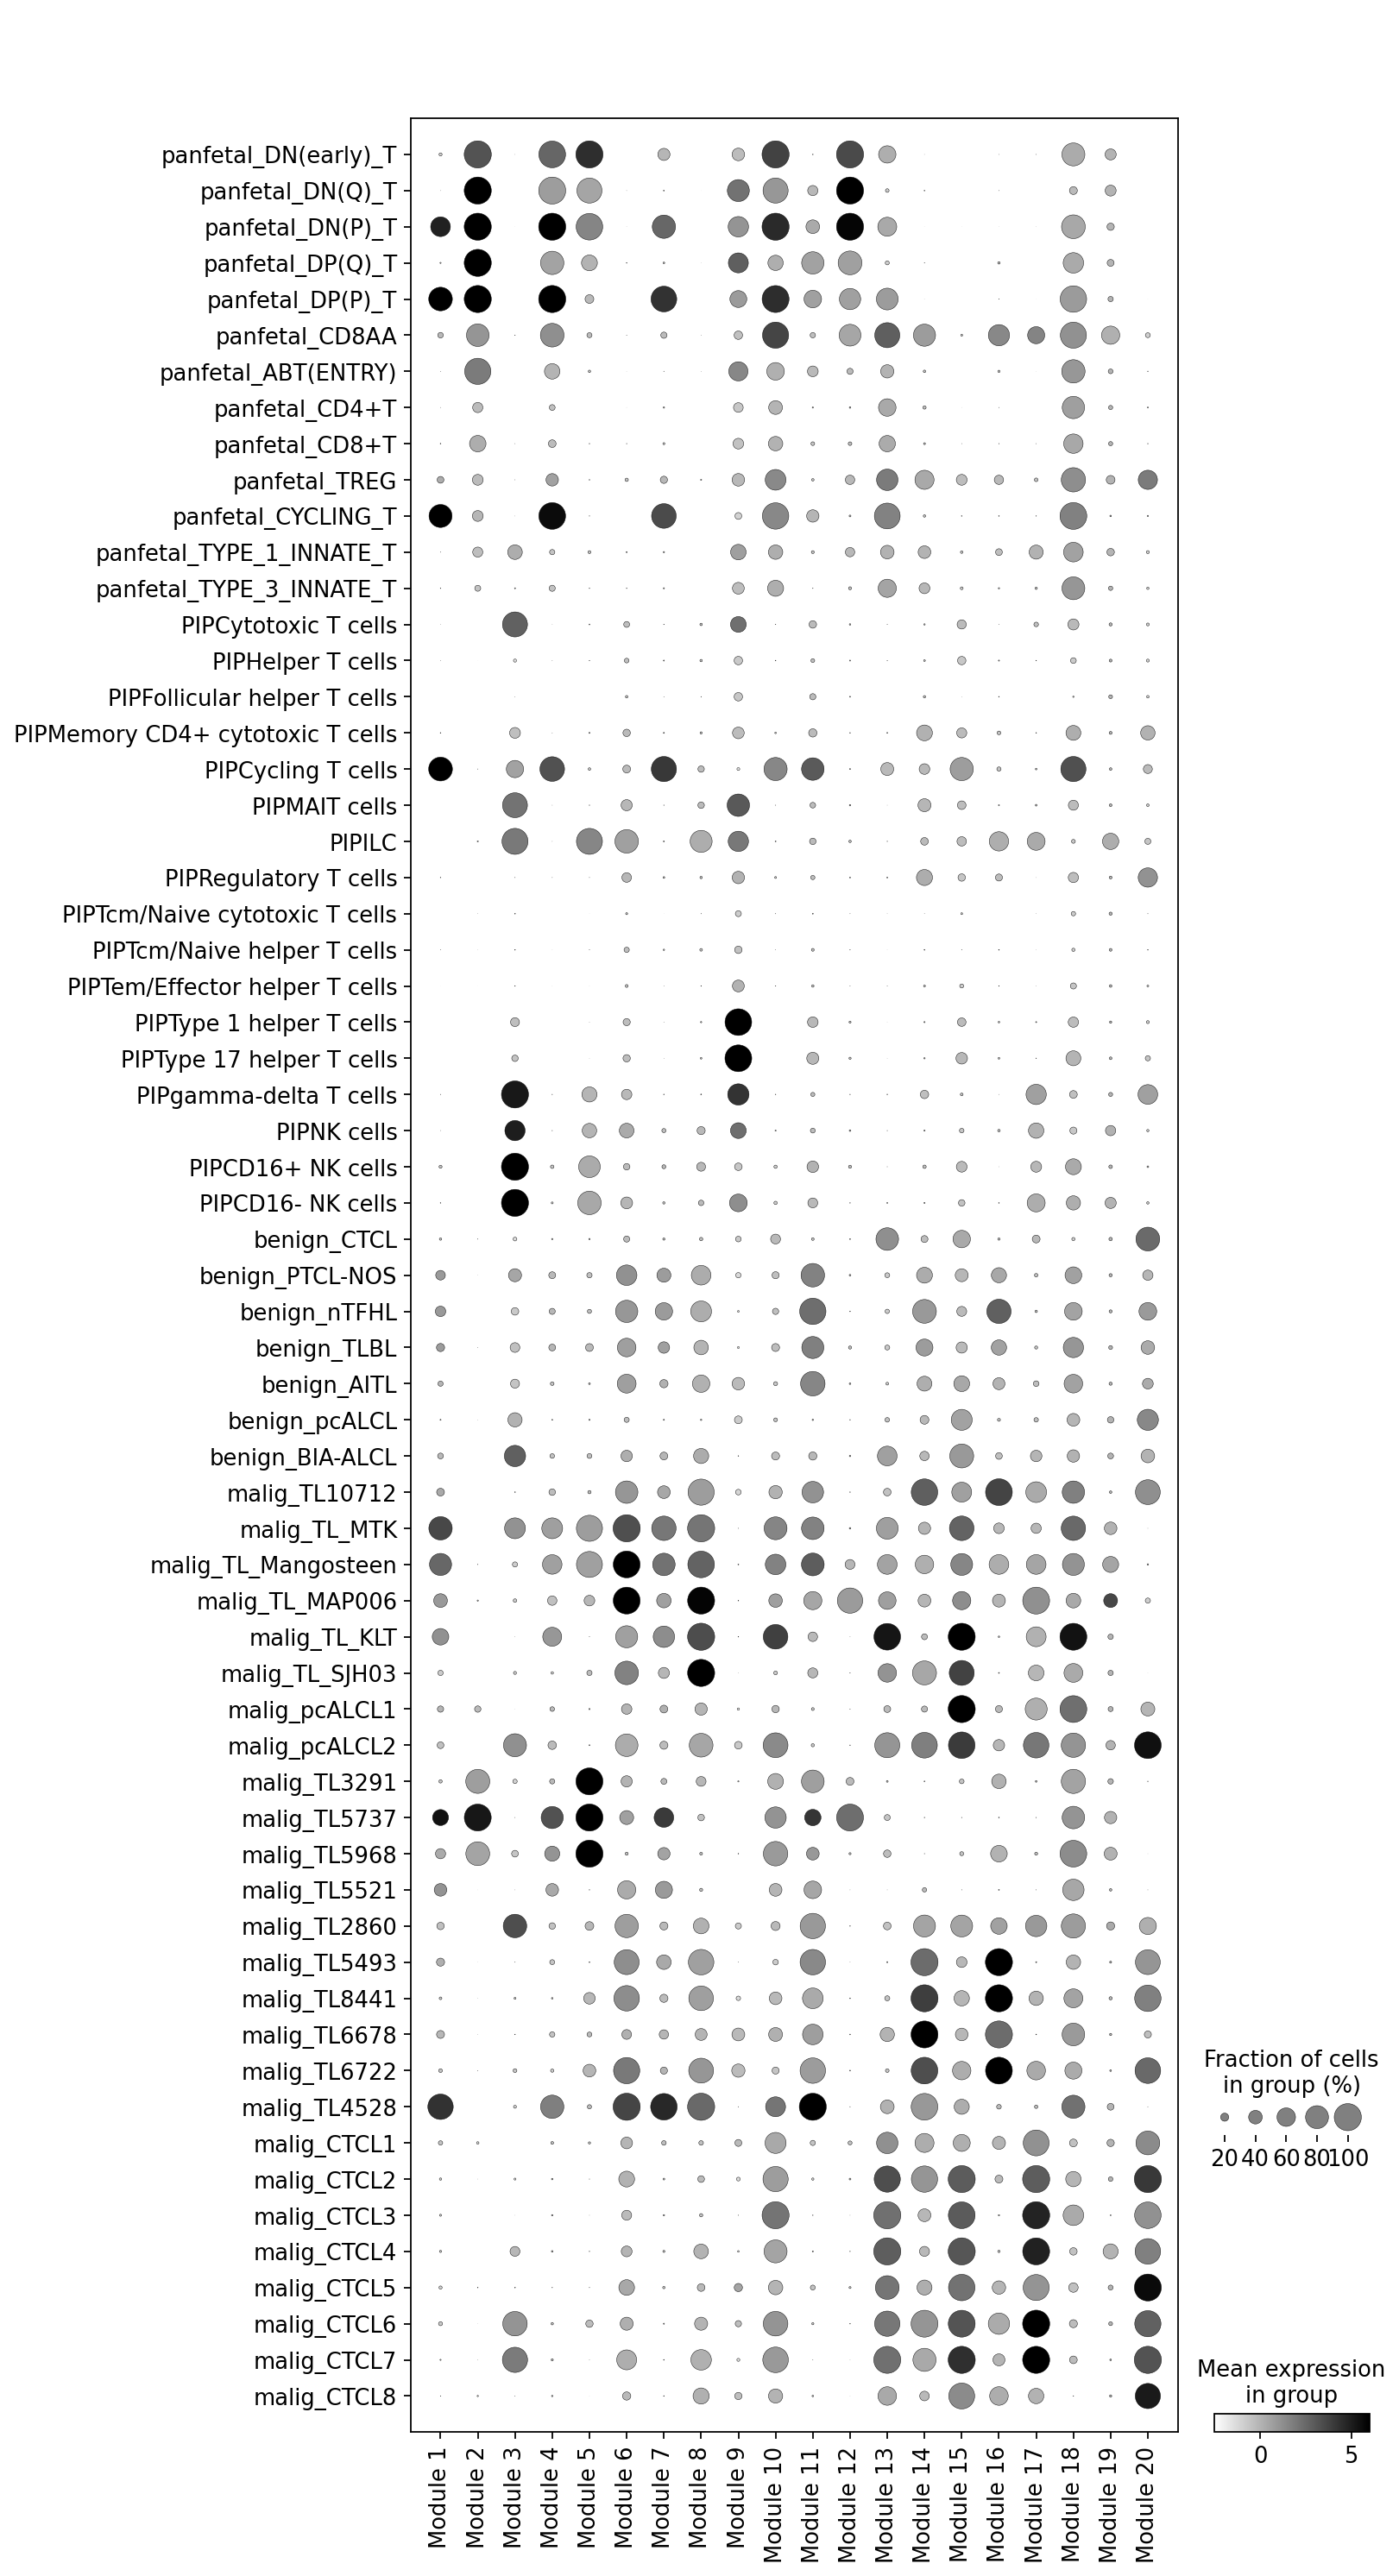

In [35]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
dp = sc.pl.dotplot(adata, module_cols, groupby='malignant_call_donor', 
                   dendrogram = False, vmax=6, cmap='gray_r',categories_order = categories_order, save='.20250512.pdf')